In [1]:
import sys
import json
import torch
import sklearn
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

from datetime import datetime

from torch.utils import data
from scipy.stats import spearmanr

# Our code
from data_generator import Dataset
from lstm import LSTM_model
from cnn import CNN

In [2]:
train_file = "stab_data/stability_train.json"
valid_file = "stab_data/stability_valid.json"
test_file = "stab_data/stability_test.json"

In [3]:
class stab_dataset(Dataset):
    def __init__(self, filename, max_seq_len, output_type="onehot", acids="ACDEFGHIKLMNPQRSTVWY-"):
        elem_list = []
        label_list = []
        self.acids = acids
        self.output_type = output_type
        self.acid_dict, self.int_acid_dict = self.__gen_acid_dict__(acids)
        self.max_seq_len = max_seq_len
        self.get_prot_class=True
        # Loading the entire input file into memory
        for i, elem in enumerate(json.load(open(filename))):
            seq = elem["primary"].upper()
            if self.__is_legal_seq__(seq):
                elem_list.append(seq)
                label_list.append(elem["stability_score"][0])
        '''
        for i, elem in enumerate(SeqIO.parse(filename, "fasta")):
            if self.__is_legal_seq__(elem.seq.upper()):
                elem_list.append(elem.seq.upper())
                if get_prot_class:
                    label_list.append(prot_class_re.search(elem.description).group(1))
        '''
        
        self.data = elem_list
        self.prot_labels = label_list

    def __len__(self):
        return len(self.data)

class lin_reg(nn.Module):
    def __init__(self, input_size, output_size):
        super(lin_reg, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        #x = x.long()
        return self.linear(x)


In [4]:
use_cuda = torch.cuda.is_available() and True
print("Using GPU:", use_cuda)
processor = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

Using GPU: False


In [5]:
max_seq_len = 500
batch_size = 64


scope_file = "scope_data_40.fasta"
acids = "ACDEFGHIKLMNOPQRSTUVWY-"

stab_train = stab_dataset(train_file, 500, output_type="embed", acids=acids)
stab_valid = stab_dataset(valid_file, 500, output_type="embed", acids=acids)
stab_test = stab_dataset(test_file, 500, output_type="embed", acids=acids)

train_generator = data.DataLoader(stab_train, batch_size=batch_size, shuffle=True, num_workers=8)
valid_generator = data.DataLoader(stab_valid, batch_size=batch_size, shuffle=True, num_workers=8)
test_generator = data.DataLoader(stab_test, batch_size=batch_size, shuffle=True, num_workers=8)

loaded_params = torch.load("temp_best_cnn_model.pth",map_location=torch.device('cpu'))

#model = LSTM_model(len(acids), embed_size, hidden_dim, hidden_layers, max_seq_len, batch_size, processor, dropout=0).to(processor)
model = CNN(**loaded_params["args_dict"]).to(processor)
model.load_state_dict(loaded_params["state_dict"])

top_model = lin_reg(200, 1).to(processor)

In [6]:
batches = float("inf")
time_diff = 0
no_improv = 0
min_loss = float("inf")
val_loss = float("inf")
epochs = 1
loss_function = nn.MSELoss() 
optimiser = torch.optim.SGD(top_model.parameters(), lr=0.0001)

for epoch in range(epochs):
    for i, (batch, labels, valid_elems, scores) in enumerate(train_generator):

        # Keeping track of stuff
        start_time = datetime.now()
        
        est_time_left = str(time_diff*(min(batches, stab_train.__len__()/batch_size) - i) + (time_diff*min(batches, stab_train.__len__()/batch_size)) * (epochs - (epoch+1))).split(".")[0]
        sys.stdout.write("\rEpoch: {0}. Batch: {1}. Train: {2:.5f}. Valid: {5:.5f} Estimated time left: {3}. Best: {4} batches ago.".format(epoch+1, i+1, min_loss, est_time_left, no_improv, val_loss))
        
        #with torch.no_grad():
        #model.eval()
        top_model.train()
        scores.requires_grad_(True)
        batch = batch.to(processor)
        labels = labels.to(processor)
        scores = scores.to(processor)
        
        
        # Transposing from (batch x seq x feature_size) to (seq x batch x feature_size)
        #batch = batch.transpose(0,1)
        
        out, hidden = model(batch)
        
        #reduced_hidden = torch.mean(hidden, dim=0)
        #pred = top_model(test).squeeze(1)
        pred = top_model(hidden).squeeze(1)

        #print(pred[:64])

        loss = loss_function(pred, scores)
        #print("Loss:", loss)
        loss.backward()
        optimiser.step()
        
        if loss.item() < min_loss:
            torch.save(top_model.state_dict(), "temp_CNN_best_down_model.pth")
            min_loss = loss.item()
            no_improv = 0
        else:
            no_improv += 1
        
        if i%50 == 0:
            with torch.no_grad():
                top_model.eval()
                val_loss = 0
                for j, (batch, labels, valid_elems, scores) in enumerate(valid_generator):
                    scores.requires_grad_(True)
                    batch = batch.to(processor)
                    labels = labels.to(processor)
                    scores = scores.to(processor)
                    
        
                    out, hidden = model(batch)
        
                    #reduced_hidden = torch.mean(hidden, dim=0)
        
                    pred = top_model(hidden).squeeze(1)

                    val_loss += loss_function(pred, scores).item()

                    if j+1 >= 5:
                        break
                val_loss /= j + 1

        # For tracking progress
        end_time = datetime.now()
        time_diff = end_time - start_time
        
        # Breaking when it's run through the given number of batches
        if i+1 >= batches:
            
            break
    torch.save(top_model.state_dict(), "temp_CNN_down_model.pth")
    

Epoch: 1. Batch: 838. Train: 0.23929. Valid: 1.00461 Estimated time left: 0:00:00. Best: 482 batches ago..

In [7]:
full_preds = None
load_top = False
if load_top:
    top_model.load_state_dict(torch.load("temp_CNN_down_model.pth"))

    
for i, (batch, labels, valid_elems, scores) in enumerate(test_generator):
    scores.requires_grad_(True)
    batch = batch.to(processor)
    labels = labels.to(processor)
    scores = scores.to(processor)
    
    out, hidden = model(batch)
    
    preds = top_model(hidden).squeeze(1)

    if full_preds is None:
        full_preds = preds.detach()
        full_scores = scores.detach()
    else:
        full_preds = torch.cat((full_preds, preds.detach()))
        full_scores = torch.cat((full_scores, scores.detach()))

torch.Size([12851])
torch.Size([12851])
tensor([-2.3769, -2.2694, -2.2580, -1.9725, -2.3830, -2.1842, -2.2658, -2.0310,
        -2.3169, -2.3219, -2.0845, -2.3601, -2.0998, -2.1426, -2.3096, -2.3224,
        -2.1445, -2.0848, -2.1320, -2.2268, -2.2988, -2.0411, -2.2292, -2.3133,
        -2.3504, -1.9806, -2.2823, -2.0754, -2.0017, -2.3436, -2.1988, -2.0611,
        -2.2904, -2.3472, -1.9571, -2.3351, -2.0844, -2.2669, -2.2629, -2.1127,
        -2.0762, -2.0603, -1.9512, -2.0923, -2.2987, -1.9744, -2.0223, -2.2848,
        -2.3458, -2.2971, -2.3727, -2.3069, -2.3112, -2.3350, -2.2300, -2.1029,
        -2.1788, -2.0964, -2.2585, -2.2702, -2.0176, -2.2776, -2.2642, -2.0818])
tensor([0.9200, 1.6600, 1.7000, 1.0300, 1.8200, 1.3400, 0.9500, 1.2300, 1.2800,
        1.2200, 1.3800, 0.8700, 1.0900, 1.0600, 1.0500, 0.9500, 1.1100, 0.8300,
        0.9300, 1.0600, 0.9900, 1.0800, 0.3700, 0.2600, 0.7900, 1.2000, 1.6600,
        1.1500, 0.1700, 1.5800, 0.8700, 0.9400, 1.7000, 1.5900, 1.1700, 1.3200,

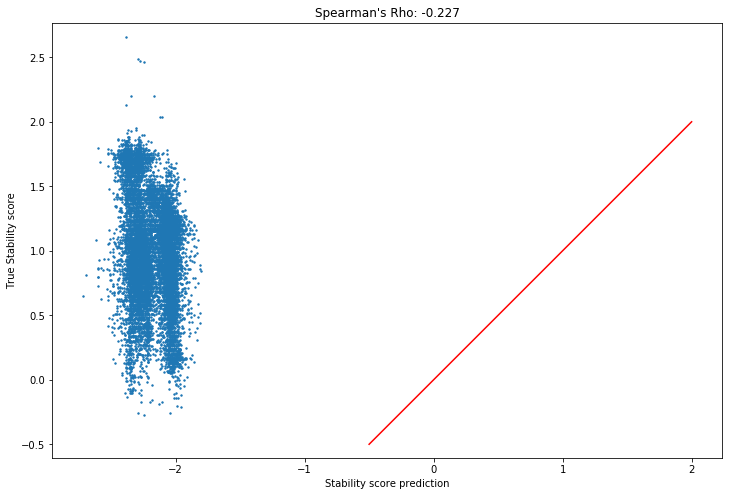

In [8]:
print(full_preds.size())
print(full_scores.size())
print(full_preds[:64])
print(full_scores[:64])
spearman_vals = spearmanr(full_preds.cpu(), full_scores.cpu())
print(spearman_vals)

fig, ax = plt.subplots(1, figsize=(12,8))
ax.scatter(full_preds.cpu(), full_scores.cpu(), s=2)
line = np.linspace(-0.5,2, 10)
ax.plot(line, line, color="red")
ax.set_title("Spearman's Rho: {0:.3f}".format(spearman_vals[0]))
ax.set_xlabel("Stability score prediction")
ax.set_ylabel("True Stability score")
ax.axis("equal")
fig.savefig("CNN_spearman_correlation")